In [2]:
import numpy
import joblib

from datasets import Dataset, load_dataset

import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pandas as pd
#from kaggle.api.kaggle_api_extended import KaggleApi
#
# log into kaggle
#api = KaggleApi()
#api.authenticate()
 
#api.dataset_download_files('Cornell-University/arxiv')
 
# unzip the data
# zip = zipfile.ZipFile(kaggle_project + '.zip').\
#    extractall()
 
# load the data
# churn_df = pd.read_csv('Churn_Modelling.csv')

/home/azureuser/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#import pandas
#pandas.read_json('arxiv/arxiv-metadata-oai-snapshot.json', lines=True)

dataset = load_dataset("json", data_files="arxiv/arxiv-metadata-oai-snapshot.json")

In [3]:
dataset = dataset.remove_columns(["id", "authors", "authors_parsed", "versions", "doi", "submitter", "report-no", "journal-ref", "license", "comments"])

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'categories', 'abstract', 'update_date'],
        num_rows: 2575090
    })
})

In [5]:
pandas_dataset = dataset["train"].to_pandas()
pandas_dataset.describe(include='all')

,title,categories,abstract,update_date
count,2575090,2575090,2575090,2575090
unique,2570983,85709,2573307,NaN
top,Discussion of: A statistical analysis of multi...,astro-ph,This paper has been withdrawn.\n,NaN
freq,12,86911,91,NaN
mean,NaN,NaN,NaN,2017-06-04 02:46:12
min,NaN,NaN,NaN,2007-05-23 00:00:00
25%,NaN,NaN,NaN,2013-05-15 00:00:00
50%,NaN,NaN,NaN,2018-04-18 00:00:00
75%,NaN,NaN,NaN,2022-03-03 00:00:00
max,NaN,NaN,NaN,2024-10-04 00:00:00


In [6]:
pandas_dataset.drop_duplicates(subset=['abstract'], keep=False)

,title,categories,abstract,update_date
0,Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26
1,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13
2,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13
3,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,2007-05-23
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15
...,...,...,...,...
2575085,On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,2009-10-30
2575086,Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,2016-11-18
2575087,Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,2009-10-30
2575088,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,2009-10-30


array([[<Axes: title={'center': 'update_date'}>]], dtype=object)

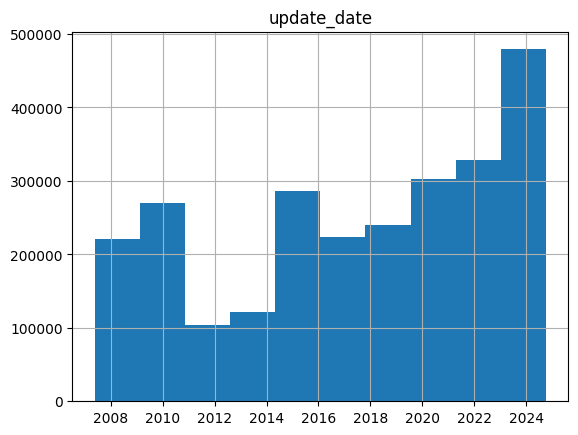

In [7]:
pandas_dataset.hist(column='update_date')

In [8]:
pandas_dataset.to_csv('arxiv/pd_processed.csv')

In [9]:
dataset = load_dataset("csv", data_files='arxiv/pd_processed.csv')

Generating train split: 2575090 examples [00:21, 118863.41 examples/s]


## Preprocessing

In [10]:


sw = stopwords.words('english')
def clean_text(row):
    text = row["abstract"]
    text = re.sub(r"[^a-zA-Z \n-]+", "", text) # Removing non alphabet characters
    text = re.sub(r"[\n-]+", " ", text) # Replacing new lines and dash with space non alphabet characters
    text = re.sub(r"\b\w{1,3}\b", "", text) # Remove words that are less than 3 letters short
    
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords and lemmatize words
    row["abstract"] = text
    return row
    
updated_dataset = dataset.map(clean_text)

Map: 100%|███████████████████████████████████████████████████████████| 2575090/2575090 [21:11<00:00, 2025.45 examples/s]


In [11]:
def clean_title(row):
    text = row["title"]
    text = re.sub(r"[^a-zA-Z \n-]+", "", text) # Removing non alphabet characters
    text = re.sub(r"[\n-]+", " ", text) # Replacing new lines and dash with space non alphabet characters
    text = re.sub(r"\b\w{1,3}\b", "", text) # Remove words that are less than 3 letters short
    
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords and lemmatize words
    row["title"] = text
    return row
    
updated_dataset = updated_dataset.map(clean_title)

Map: 100%|███████████████████████████████████████████████████████████| 2575090/2575090 [04:25<00:00, 9686.23 examples/s]


In [12]:
def concat_content(row):
    row["content"] = row["title"] + " " + row["abstract"]
    return row
updated_dataset = updated_dataset.map(concat_content)

Map: 100%|██████████████████████████████████████████████████████████| 2575090/2575090 [02:22<00:00, 18027.53 examples/s]


In [13]:
def clean_categories(row):
    text = row["categories"]
    text = re.sub(r"\ .*$", "", text) # Removes categories other than the first one
    text = re.sub(r"\..*$", "", text) # Removes Sub-Categories
    if (text == "patt-sol" or text == "solv-int" or text == "plasm-ph" or text == "astro-ph" or text == "cond-mat" or text == "mtrl-th" or text == "supr-con" or text == "gr-qc" or text == "hep-ex" or text == "hep-lat" or text == "hep-ph" or text == "hep-th" or text == "math-ph" or text == "nlin" or text == "nucl-ex" or text == "nucl-th" or text == "quant-ph" or text == "acc-phys" or text == "ao-sci"  or text == "adap-org" or text == "atom-ph" or text == "bayes-an" or text == "chao-dyn" or text == "chem-ph" or text == "comp-gas") :
        text = "physics"
    if text == "alg-geom" or text == "dg-ga" or text == "funct-an" or text == "q-alg":
        text = "math"
    if text == "cmp-lg":
        text = "cs"
    row["categories"] = text
    return row
    
updated_dataset = updated_dataset.map(clean_categories)

Map: 100%|██████████████████████████████████████████████████████████| 2575090/2575090 [02:38<00:00, 16233.12 examples/s]


In [14]:
updated_dataset.data
updated_dataset["train"].to_csv("arxiv/fully_processed.csv")

Creating CSV from Arrow format: 100%|███████████████████████████████████████████████| 2576/2576 [00:48<00:00, 53.44ba/s]


3877021293

## Classification

In [9]:
x_train, x_test, y_train, y_test = train_test_split(updated_dataset["train"]["content"], updated_dataset["train"]["categories"], test_size = 0.15, random_state = 42)    
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=500)        
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vectorizer.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

x_test_counts = count_vectorizer.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [10]:
#Backup in case of kernel crash
joblib.dump(x_train_tfidf, 'x_train_tfidf.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [ ]:
#Restore
x_train_tfidf = joblib.load('x_train_tfidf.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

In [11]:
svc = LinearSVC()
svc.fit(x_train_tfidf, y_train)
y_pred_linear = svc.predict(x_test_tfidf)
print(classification_report(y_test, y_pred_linear))

              precision    recall  f1-score   support

          cs       0.79      0.88      0.84     82248
        econ       0.61      0.01      0.02      1131
        eess       0.53      0.04      0.07      8025
        math       0.82      0.87      0.85     76596
     physics       0.93      0.95      0.94    204572
       q-bio       0.62      0.13      0.21      4435
       q-fin       0.78      0.03      0.06      1701
        stat       0.65      0.34      0.45      7556

    accuracy                           0.87    386264
   macro avg       0.72      0.41      0.43    386264
weighted avg       0.86      0.87      0.86    386264



In [14]:
print(accuracy_score(y_test, y_pred_linear))

0.8721159621398836


## Visualizations

### Word Cloud

In [3]:
df = pd.read_csv('arxiv/fully_processed.csv')
all_text = df["title"].str.cat(sep=" ")

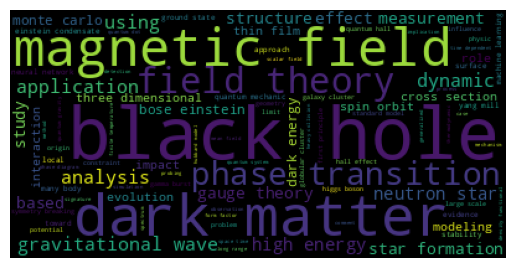

In [9]:
word_cloud = WordCloud().generate(all_text)
plt.axis("off")
plt.imshow(word_cloud)
word_cloud.to_file('visualization/all_word_cloud.png')

In [16]:
physics = df[df["categories"] == "physics"]
physics_text = physics["title"].str.cat(sep=" ")
cs = df[df["categories"] == "cs"]
cs_text = cs["title"].str.cat(sep=" ")
econ = df[df["categories"] == "econ"]
econ_text = econ["title"].str.cat(sep=" ")
eess = df[df["categories"] == "eess"]
eess_text = eess["title"].str.cat(sep=" ")
math = df[df["categories"] == "math"]
math_text = math["title"].str.cat(sep=" ")
q_bio = df[df["categories"] == "q-bio"]
q_bio_text = q_bio["title"].str.cat(sep=" ")
q_fin = df[df["categories"] == "q-fin"]
q_fin_text = q_fin["title"].str.cat(sep=" ")
stat = df[df["categories"] == "stat"]
stat_text = stat["title"].str.cat(sep=" ")

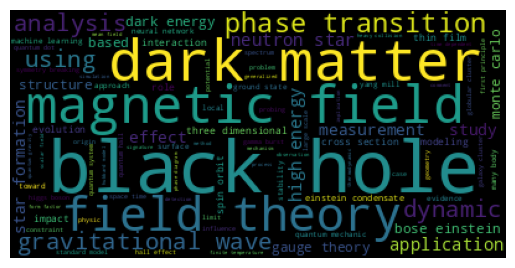

In [10]:
physics_cloud = WordCloud().generate(physics_text)
plt.axis("off")
plt.imshow(physics_cloud)
physics_cloud.to_file('visualization/physics_word_cloud.png')

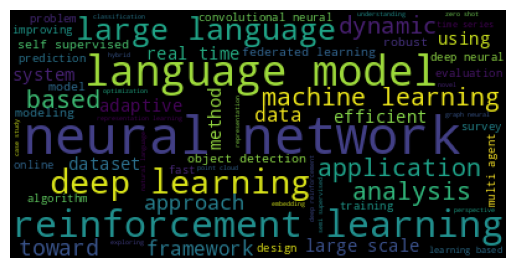

In [11]:
cs_cloud = WordCloud().generate(cs_text)
plt.axis("off")
plt.imshow(cs_cloud)
cs_cloud.to_file('visualization/cs_word_cloud.png')

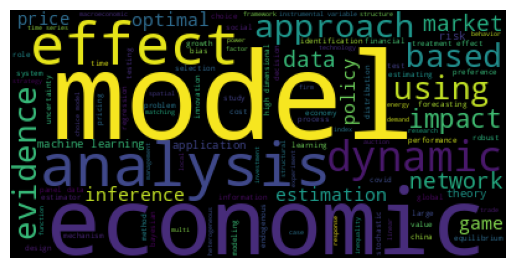

In [12]:
econ_cloud = WordCloud().generate(econ_text)
plt.axis("off")
plt.imshow(econ_cloud)
econ_cloud.to_file('visualization/econ_word_cloud.png')

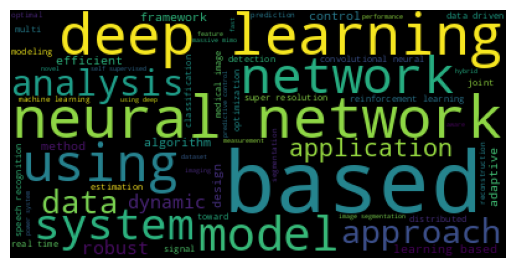

In [13]:
eess_cloud = WordCloud().generate(eess_text)
plt.axis("off")
plt.imshow(eess_cloud)
eess_cloud.to_file('visualization/eess_word_cloud.png')

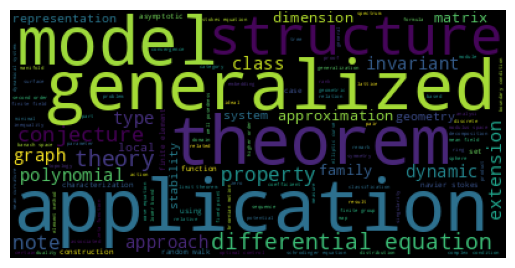

In [14]:
math_cloud = WordCloud().generate(math_text)
plt.axis("off")
plt.imshow(math_cloud)
math_cloud.to_file('visualization/math_word_cloud.png')

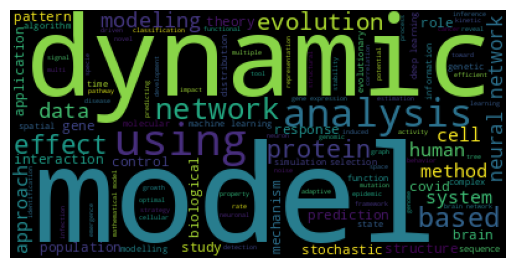

In [17]:
q_bio_cloud = WordCloud().generate(q_bio_text)
plt.axis("off")
plt.imshow(q_bio_cloud)
q_bio_cloud.to_file('visualization/q-bio_word_cloud.png')

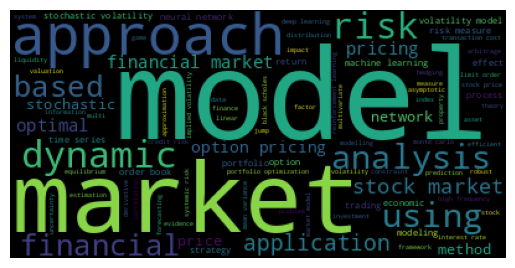

In [18]:
q_fin_cloud = WordCloud().generate(q_fin_text)
plt.axis("off")
plt.imshow(q_fin_cloud)
q_fin_cloud.to_file('visualization/q_fin_word_cloud.png')

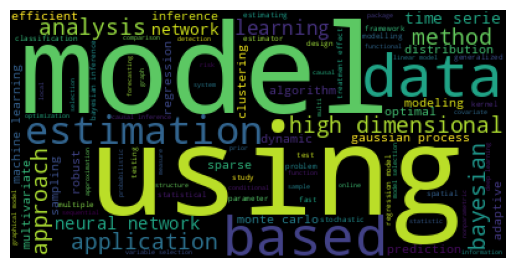

In [19]:
stat_cloud = WordCloud().generate(stat_text)
plt.axis("off")
plt.imshow(stat_cloud)
stat_cloud.to_file('visualization/stat_word_cloud.png')